In [2]:
import pandas as pd
import numpy as np
import random
import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.ensemble import IsolationForest

### 1. Define the desired distribution

#### Define distribution

In [3]:
# hour (in utc), number of request
request_distribution_hour = [
    [0, 2725],
    [1, 5751],
    [2, 13356],
    [3, 15238],
    [4, 13734],
    [5, 11279],
    [6, 13368],
    [7, 14384],
    [8, 15164],
    [9, 11635],
    [10, 8402],
    [11, 7086],
    [12, 7173],
    [13, 7508],
    [14, 7460],
    [15, 6735],
    [16, 5466],
    [17, 4244],
    [18, 2792],
    [19, 2234],
    [20, 2012],
    [21, 1650],
    [22, 1627],
    [23, 1896],
]

df_distribution = pd.DataFrame(request_distribution_hour, columns=['hour','value'])
df_distribution['probability'] = df_distribution['value'] / df_distribution['value'].sum()
df_distribution

,hour,value,probability
0,0,2725,0.014897
1,1,5751,0.031440
2,2,13356,0.073016
3,3,15238,0.083305
4,4,13734,0.075082
5,5,11279,0.061661
6,6,13368,0.073082
7,7,14384,0.078636
8,8,15164,0.082900
9,9,11635,0.063607


#### Plot Distribution

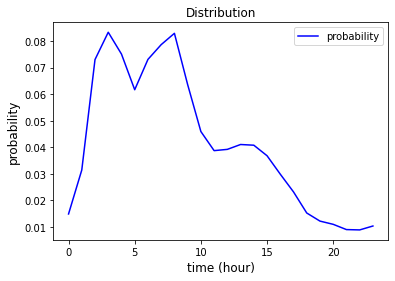

In [8]:
x = df_distribution.index
y = df_distribution['probability']
plt.plot(x, y, "-b", label="probability")
plt.legend(loc="upper right")
plt.title("Distribution")
plt.xlabel('time (hour)', fontsize=12)
plt.ylabel('probability', fontsize=12)
plt.show()

In [10]:
%%html
<style>
table {float:left}
</style>

### 2. Generate Dataset for each asset
#### Description
#####  formula
`L(i,t) = P(hour(t)) * R + C(i,t) +  A(i,t)`

where
- P : probability of specific hour
- R : average number of requests per second (constant)
- C : white noise of each asset in time t (Random from 0 to max C)
- A : number of abnormal Log in time t   


- i : asset
- t : datetime (10 second interval)

#####  Asset  Description
| Asset | Max C | A |
| --- | --- | --- |
| L1 | Low | Low |
| L2 | Medium | Low |
| L3 | High | Low |
| L4 | Low | Medium |
| L5 | Medium | Medium |
| L6 | High | Medium |
| L7 | Low | High |
| L8 | Medium | High |
| L9 | High | High |



#####  Asset  Value
| Asset | Max C | A |
| --- | --- | --- |
| L1 | 20 | 20 |
| L2 | 100 | 20 |
| L3 | 200 | 20 |
| L4 | 20 | 100 |
| L5 | 100 | 100 |
| L6 | 200 | 100 |
| L7 | 20 | 200 |
| L8 | 100 | 200 |
| L9 | 200 | 200 |

#### Define Variable

In [12]:
abnormal_range = pd.date_range('2022-08-13 00:00:00', '2022-08-14 00:00:00', freq="1H")
R = 100
A_range = [
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 20} ], # L1
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 20} ], # L2
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 20} ], # L3
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 100} ], # L4
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 100} ], # L5
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 100} ], # L6
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 200} ], # L7
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 200} ], # L8
    [ {'date_range': pd.date_range('2022-08-06 00:00:00', '2022-08-07 00:00:00', freq="1H"), 'value': 200} ], # L9
   
]
C = [
    20, # L1
    100, # L2
    200, # L3
    20, # L4
    100, # L5
    200, # L6
    20, # L7
    100, # L8
    200, # L9
]

#### Generate dataset

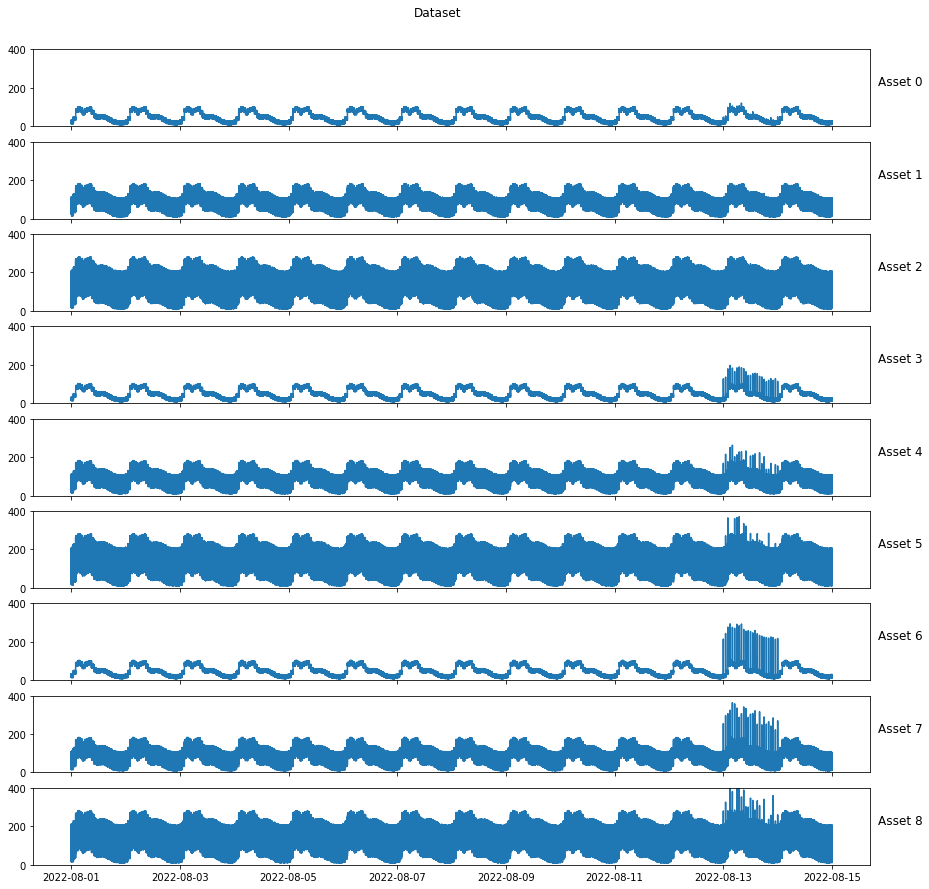

In [21]:
date_range = pd.date_range('2022-08-01 00:00:00', '2022-08-15 00:00:00', freq="10S")
df_date = pd.DataFrame(index=date_range)
df_date['hour'] = df_date.index.hour
df_date['weekday'] = df_date.index.weekday

n_row = df_date.shape[0]

n_asset = len(C)
fig, axs = plt.subplots(nrows=n_asset, sharex=True)
fig.suptitle('Dataset',y=0.92,x=0.5)
fig.set_figheight(15)
fig.set_figwidth(15)


for i in range(n_asset):
    for abnormal in A_range[i]:
        df_date.loc[abnormal_range, 'A'] = abnormal['value']

    df_date['A'] = df_date['A'].fillna(0)
    df_date['C'] = np.random.randint(0,C[i], size=(n_row,1))
    df_merge = df_date.reset_index().merge(df_distribution[['hour', 'probability']], how='left')
    df_merge = df_merge.rename(columns={'probability':'P', 'index': 'datetime'})

    ## L(i,t) = P(hour(t)) * R + C(i,t) +  A(i,t)  -> for every 10 second    
    df_merge['n_request'] = df_merge['P'] * R * 10 + df_merge['C'] + df_merge['A']
    df_merge['n_request'] = df_merge['n_request'].astype('int')
    df_merge.loc[ df_merge.A > 0, 'abnormal'] = 1
    df_merge['abnormal'] = df_merge['abnormal'].fillna(0)
    
    df_merge.to_csv(f'input/asset_{i+1}.csv', index=False)
    
    
    
    x = df_merge['datetime']
    y = df_merge['n_request']
    axs[i].set_title(f'Asset {i}', ha='left', va='center',y=0.5,x=1.009)
    axs[i].set_ylim([0, 400])
    axs[i].plot(x, y)
    
plt.show()

### Display Example Data

In [3]:
df_asset01 = pd.read_csv(f'input/asset_1.csv')

In [5]:
df_asset01

,datetime,hour,weekday,A,C,P,n_request,abnormal
0,2022-08-01 00:00:00,0,0,0.0,0,0.014897,14,0.0
1,2022-08-01 00:00:10,0,0,0.0,7,0.014897,21,0.0
2,2022-08-01 00:00:20,0,0,0.0,0,0.014897,14,0.0
3,2022-08-01 00:00:30,0,0,0.0,16,0.014897,30,0.0
4,2022-08-01 00:00:40,0,0,0.0,16,0.014897,30,0.0
...,...,...,...,...,...,...,...,...
120956,2022-08-14 23:59:20,23,6,0.0,12,0.010365,22,0.0
120957,2022-08-14 23:59:30,23,6,0.0,3,0.010365,13,0.0
120958,2022-08-14 23:59:40,23,6,0.0,0,0.010365,10,0.0
120959,2022-08-14 23:59:50,23,6,0.0,13,0.010365,23,0.0


#### Abnormal case of Asset L1

In [6]:
df_asset01[df_asset01['abnormal'] > 0]

,datetime,hour,weekday,A,C,P,n_request,abnormal
103680,2022-08-13 00:00:00,0,5,20.0,14,0.014897,48,1.0
104040,2022-08-13 01:00:00,1,5,20.0,3,0.031440,54,1.0
104400,2022-08-13 02:00:00,2,5,20.0,5,0.073016,98,1.0
104760,2022-08-13 03:00:00,3,5,20.0,16,0.083305,119,1.0
105120,2022-08-13 04:00:00,4,5,20.0,11,0.075082,106,1.0
105480,2022-08-13 05:00:00,5,5,20.0,7,0.061661,88,1.0
105840,2022-08-13 06:00:00,6,5,20.0,12,0.073082,105,1.0
106200,2022-08-13 07:00:00,7,5,20.0,9,0.078636,107,1.0
106560,2022-08-13 08:00:00,8,5,20.0,19,0.082900,121,1.0
106920,2022-08-13 09:00:00,9,5,20.0,14,0.063607,97,1.0
